In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [4]:
def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

In [5]:
train = pd.read_csv('../data/public.train.csv')
test = pd.read_csv('../data/public.test.csv')

train_len = train.shape[0]

df = pd.concat([train, test])

In [6]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [7]:
df.head()

,ID,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,V_A,...,V_C,I_A,I_B,I_C,efficiency,efficiency_A,efficiency_B,efficiency_C,wind_direction,wind_speed
0,10,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,729,...,725,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
1,11,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,728,...,726,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
2,12,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,731,...,720,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1
3,14,53,1474.60,225.37,1517.34,2.370656,1072.44,-15.43,-16.6,730,...,726,2.02,0.31,2.09,73.98,101.72,15.55,104.67,280,0.9
4,15,65,1548.51,233.28,1674.40,2.532091,1152.06,-14.60,-16.3,727,...,728,2.13,0.32,2.30,64.62,86.86,13.09,93.92,280,1.1


In [8]:
#异常值处理
# 改用均值
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in cols:
    df[c+'_is_out_of_upper'] = (df[c]>df[c].quantile(0.99)).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<df[c].quantile(0.01)).astype(np.int32)
#     df.loc[(df[c]>df[c].quantile(0.99))|(df[c]<df[c].quantile(0.01)),c]=np.nan
#     df[c].fillna(df[c].mean(),inplace=True)
    df[c] = np.clip(df[c],df[c].quantile(.01),df[c].quantile(0.99))

In [9]:
target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
for c in target:
    df['log_'+c] = np.log1p(df[c])

In [10]:
# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

In [12]:
# 第一阶，用其他值预测某些特征

params_layer1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'num_leaves': 48,
    'learning_rate': 0.2,
#     'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
kf_layer1 = KFold(3, shuffle=True, random_state=1991)

layer1_result = df[['ID']]

for t in target:
    print('Now, we are processing',t)
    # 特征中去掉t
    predictor_t = [c for c in target_plus if c not in['ID','y',t,t+'_is_out_of_upper',t+'_is_out_of_lower']]
    
    # 初始化结果
    val_preds = np.zeros(df.shape[0])
    
    for n_fold, (tra_idx, val_idx) in enumerate(kf_layer1.split(df)):
        tra = df.iloc[tra_idx]
        # 删掉有问题的数据
        tra.drop(tra[(tra[t+'_is_out_of_upper']==1)|(tra[t+'_is_out_of_lower']==1)].index, inplace=True)
        
        val = df.iloc[val_idx]
        # 删掉有问题的数据
        val_c = val.drop(val[(val[t+'_is_out_of_upper']==1)|(val[t+'_is_out_of_lower']==1)].index)

        train_set = lightgbm.Dataset(
            tra[predictor_t],
            tra[t]
        )

        validation_set = lightgbm.Dataset(
            val_c[predictor_t],
            val_c[t]
        )

        model = lightgbm.train(params_layer1, train_set, 
                               num_boost_round=8000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=20,
                              verbose_eval=1000)

        val_preds[val_idx] = model.predict(val[predictor_t])
        
    # 将结果保存起来
    layer1_result['predicted_'+t] = val_preds

Now, we are processing P_A
Training until validation scores don't improve for 20 rounds.


/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Early stopping, best iteration is:
[751]	valid's l1: 19.7346
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 20.6882
[2000]	valid's l1: 20.1342
Early stopping, best iteration is:
[2223]	valid's l1: 20.0669
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 20.9161
Early stopping, best iteration is:
[1308]	valid's l1: 20.6166


/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, we are processing P_avg
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 9.98123
Early stopping, best iteration is:
[1256]	valid's l1: 9.88543
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 9.93393
Early stopping, best iteration is:
[1572]	valid's l1: 9.71995
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 9.6463
Early stopping, best iteration is:
[1430]	valid's l1: 9.50549
Now, we are processing I_A
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 0.03622
Early stopping, best iteration is:
[1116]	valid's l1: 0.0360427
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 0.0372562
Early stopping, best iteration is:
[988]	valid's l1: 0.0372478
Training until validation scores don't improve for 20 rounds.
[1000]	valid's l1: 0.0355553
Early stopping, best iteration is:
[1038]	valid's l1: 0.035478
Now, we are processing P_C
Trai

In [13]:
layer1_result.head()

,ID,predicted_P_A,predicted_P_avg,predicted_I_A,predicted_P_C,predicted_I_C,predicted_P_B,predicted_I_B
0,10,852.802597,756.483336,1.462350,1097.639430,1.423265,157.043170,0.219164
1,11,1115.429979,809.889903,1.547411,1152.026598,1.550395,163.939634,0.225199
2,12,1285.242300,928.907016,1.759097,1329.374632,1.792227,162.750528,0.244601
3,14,1489.419024,1091.271283,2.056612,1498.716542,2.113968,214.498214,0.313826
4,15,1511.216897,1117.096194,2.058041,1658.668627,2.338914,240.708355,0.304332


In [14]:
layer1_result.to_pickle('../feature/predicted_value-2.pkl')

In [18]:
layer1_result = pd.read_pickle('../feature/predicted_value.pkl')

In [15]:
df = df.merge(layer1_result, on='ID', how='left')

In [16]:
for t in target:
    df['diff_'+t] = df[t]-df['predicted_'+t]

In [11]:
train = df.iloc[0:train_len]
test = df.iloc[train_len:]

In [12]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}

In [13]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y']]

In [14]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0615459	valid's score: 0.801228
Early stopping, best iteration is:
[508]	valid's l2: 0.0614762	valid's score: 0.801318
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0218491	valid's score: 0.871221
[1000]	valid's l2: 0.0186993	valid's score: 0.879705
[1500]	valid's l2: 0.0181318	valid's score: 0.881326
Early stopping, best iteration is:
[1641]	valid's l2: 0.0180839	valid's score: 0.881464
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[162]	valid's l2: 0.0125641	valid's score: 0.899208
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0499562	valid's score: 0.817321
[1000]	valid's l2: 0.0474069	valid's score: 0.821199
[1500]	valid's l2: 0.0469237	valid's score: 0.82195
Early stopping, best iteration is:
[1414]	valid's l2: 0.0468792	valid's score: 0.82202
Training until validation scores

In [15]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.852399722262


In [19]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A               147386.301654
predict_p_1       122642.480351
log_P_A           115407.717628
log_I_A            26107.769807
P_C                15860.467511
log_P_avg           9580.742280
I_A                 6655.241084
P_avg               1597.620548
I_C                 1429.933066
log_I_C              674.539319
P_B                  595.530535
I_B                  537.526659
light_strength       453.098265
log_P_B              291.201493
board_t              220.515220
wind_direction       195.516600
log_I_B              174.403615
predict_p_2          132.874186
V_B                  125.851948
V_A                  121.839249
dtype: float64

In [17]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
test[['ID','ans']].to_csv('../result/0730-8524-bagging.csv',header=False, index=False)

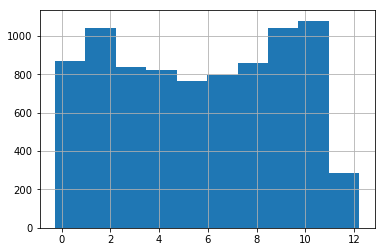

In [19]:
test['ans'].hist()

In [20]:
test['ans'].describe()

count    8409.000000
mean        5.696277
std         3.457993
min        -0.276554
25%         2.523626
50%         5.720650
75%         8.889917
max        12.215004
Name: ans, dtype: float64

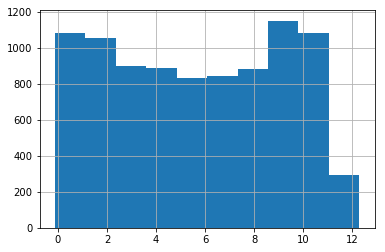

In [21]:
train['y'].hist()

In [22]:
train['y'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: y, dtype: float64